<a href="https://colab.research.google.com/github/JonJay86/textanlprac/blob/main/Kerastensorflowtutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Mon Jun 28 22:35:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    30W /  70W |    102MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install gdown
!pip install tensorflow_text

In [ ]:
!pip install wordcloud

In [ ]:
!pip install tensorflow-gpu

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
import tensorflow_text
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

%matplotlib inline
%config InlineBackend.figure_format ='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette = 'muted', font_scale = 1.2)

HAPPY_COLORS_PALETTE =['#01BEFE', '#FFDD00', '#FF7D00', '#FF006D', '#ADFF02', '#8F00FF']

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [ ]:
tf.test.is_gpu_available()

False

In [ ]:
df =pd.read_csv("/content/drive/MyDrive/archive (1).zip (Unzipped Files)/Hotel_Reviews.csv", parse_dates=['Review_Date'])

In [ ]:
df.shape

(515738, 17)

In [ ]:
df.head()

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,2017-08-03,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,2017-08-03,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,2017-07-31,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,2017-07-31,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,52.360576,4.915968
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,2017-07-24,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days,52.360576,4.915968


In [ ]:
df['review']= df["Negative_Review"] + df["Positive_Review"]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


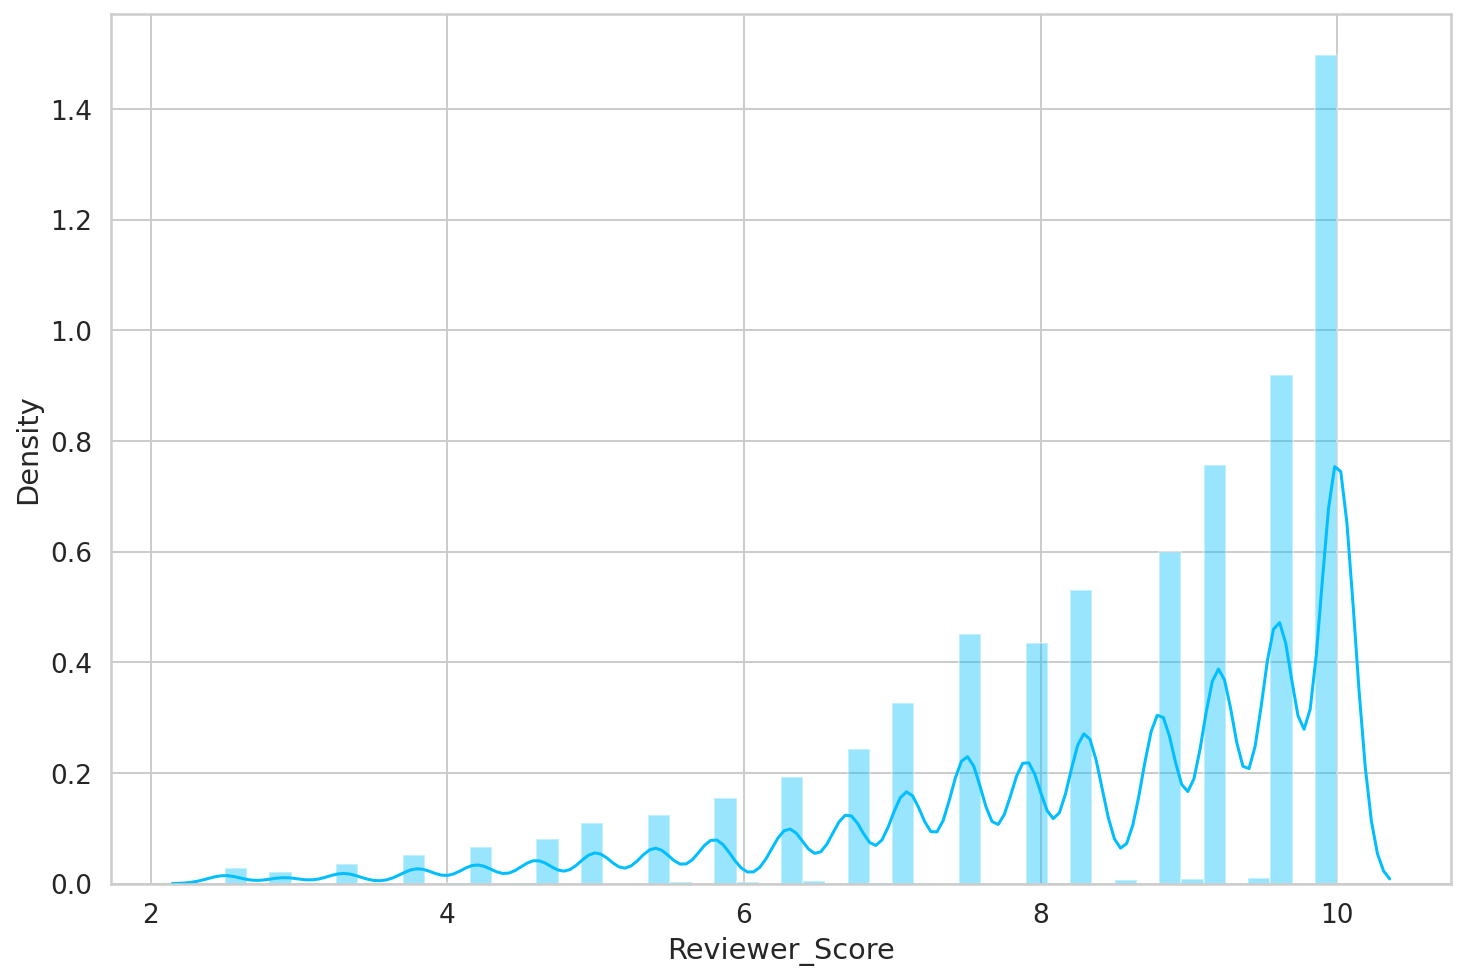

In [ ]:
sns.distplot(df.Reviewer_Score); #threshold score

In [ ]:
df["review_type"] = df["Reviewer_Score"].apply(lambda x: "bad" if x < 7 else "good")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


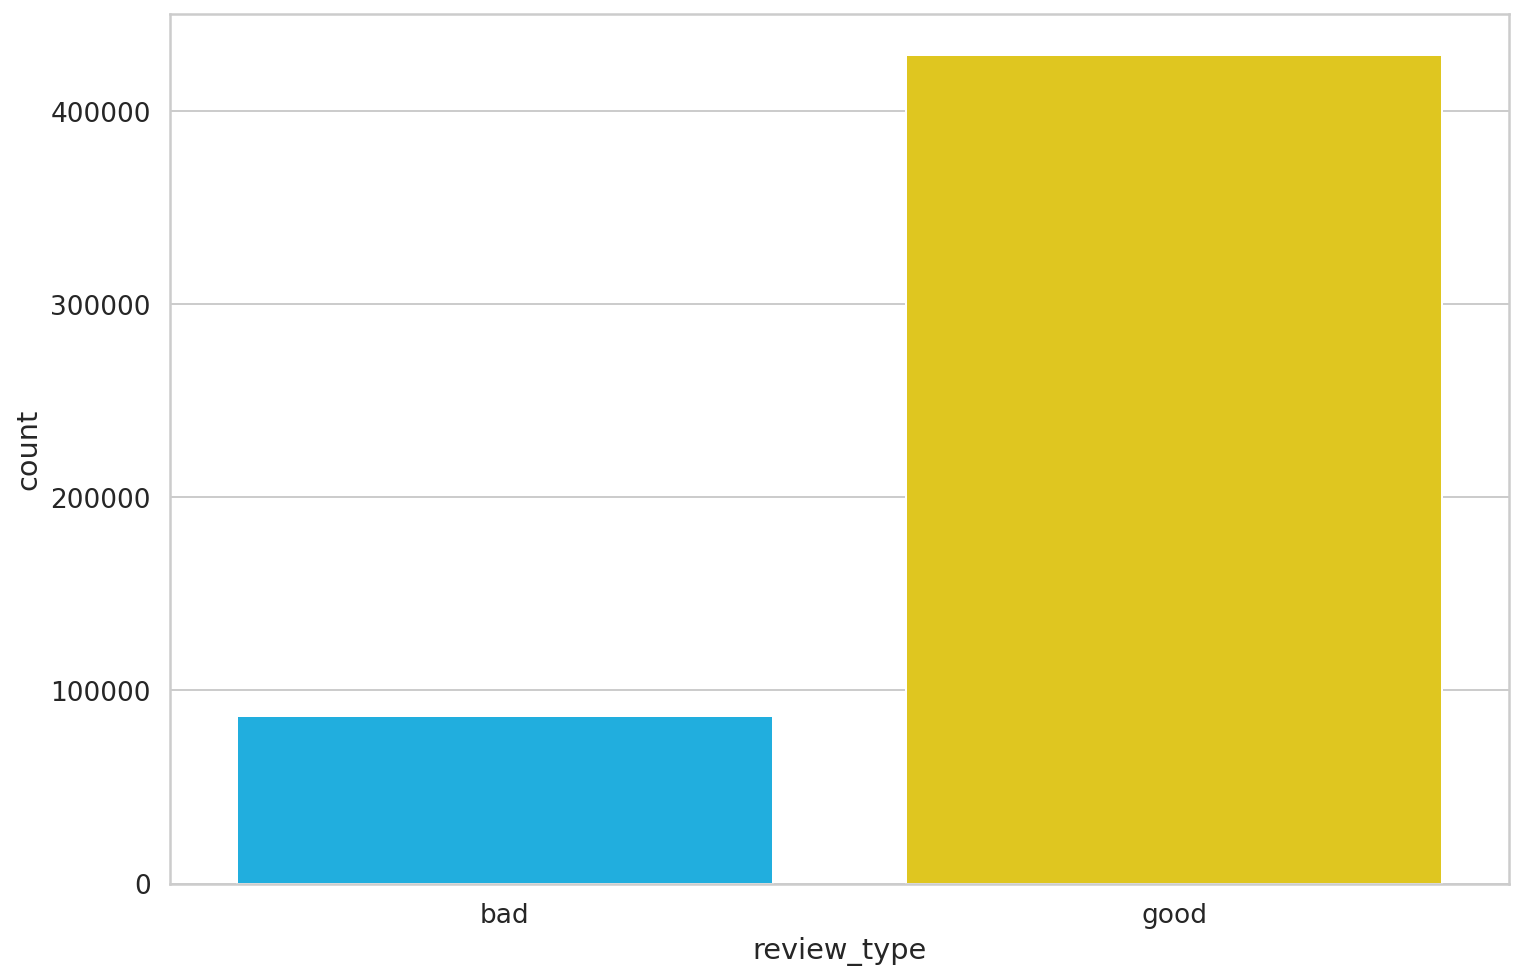

In [ ]:
sns.countplot(df.review_type) #dataset is highly imbalanced

In [ ]:
good_reviews = df[df.review_type == 'good']
bad_reviews = df[df.review_type == 'bad']

In [ ]:
good_reviews_text= ' '.join(good_reviews.review.to_numpy().tolist())
bad_reviews_text= ' '.join(bad_reviews.review.to_numpy().tolist())

In [ ]:
good_reviews_cloud = WordCloud(stopwords= STOPWORDS, background_color= "white").generate(good_reviews_text)
bad_reviews_cloud = WordCloud(stopwords= STOPWORDS, background_color= "white").generate(bad_reviews_text)

In [ ]:
def show_word_cloud(cloud):
  plt.figure(figsize=(16,10))
  plt.imshow(cloud, interpolation='bilinear')
  plt.axis('off')
  plt.show()

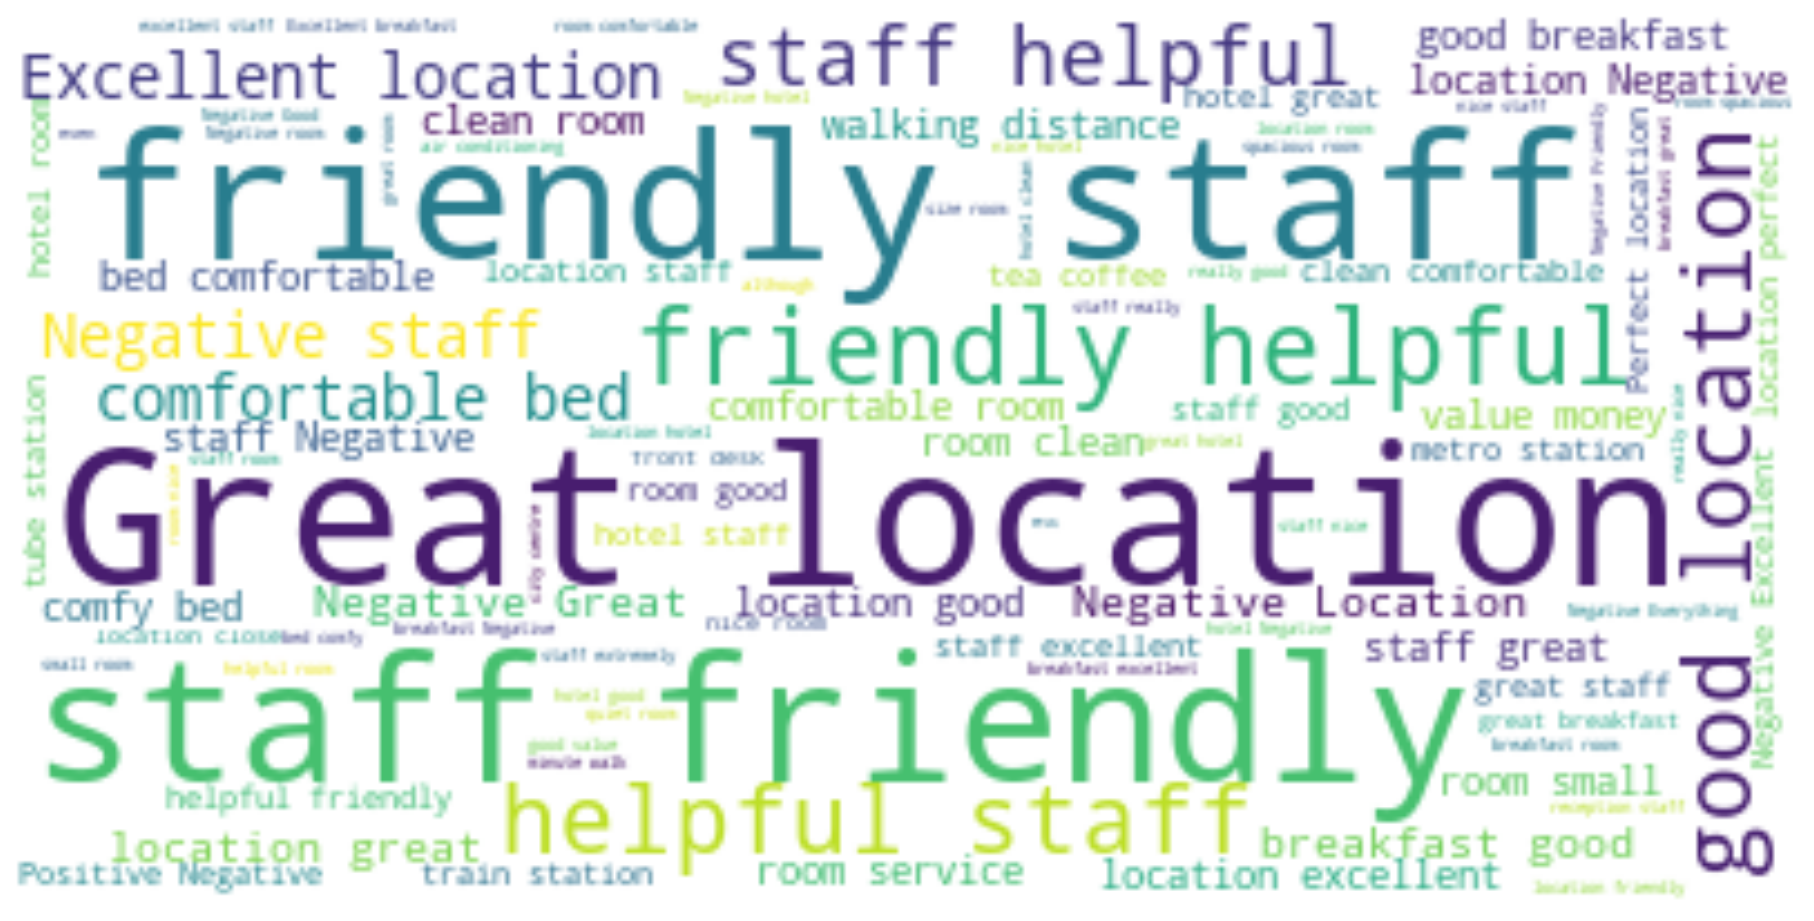

In [ ]:
show_word_cloud(good_reviews_cloud)

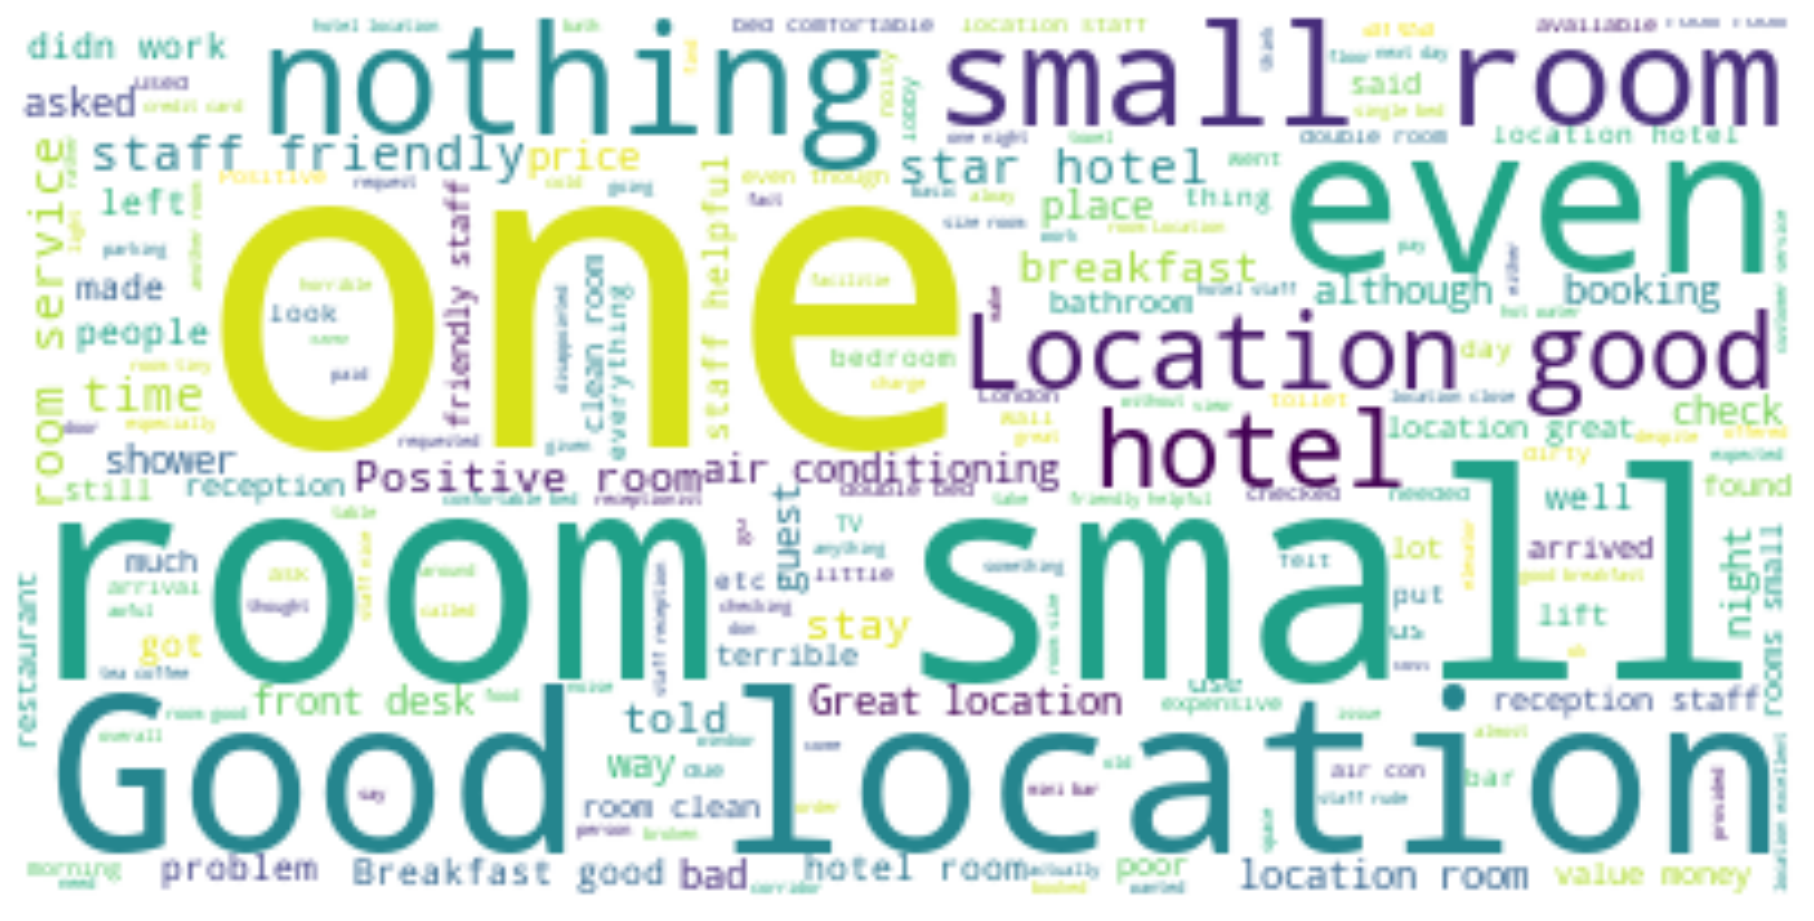

In [ ]:
show_word_cloud(bad_reviews_cloud)

In [ ]:
"""samples good reviews in the length of bad reviews"""
good_df=good_reviews.sample(n=len(bad_reviews), random_state=RANDOM_SEED)
bad_df=bad_reviews

In [ ]:
print(good_df.shape, bad_df.shape)

(86851, 19) (86851, 19)


In [ ]:
"""create large that has good and bad reviews"""
review_df=good_df.append(bad_df).reset_index(drop=True)

In [ ]:
review_df.head()

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng,review,review_type
0,Westminster Bridge Road Lambeth London SE1 7UT...,2623,2017-05-05,8.7,Park Plaza Westminster Bridge London,United Kingdom,Nothing not to like,6,12158,Location was excellent rooms were extremely c...,32,13,9.2,"[' Leisure trip ', ' Family with young childre...",90 days,51.500961,-0.116591,Nothing not to like Location was excellent r...,good
1,2 Wallenberg Place Westminster Borough London ...,687,2017-07-03,8.9,The Montcalm Marble Arch,New Zealand,Replenishment of supplies in room toiletries ...,30,2752,very comfortable bed excellent air con great ...,16,2,7.9,"[' Leisure trip ', ' Couple ', ' Executive Clu...",31 days,51.515052,-0.159239,Replenishment of supplies in room toiletries ...,good
2,Avenida Diagonal 1 Sant Mart 08019 Barcelona S...,396,2016-07-06,8.3,Barcelona Princess,United Kingdom,No Negative,0,4293,The views,3,1,8.8,"[' Leisure trip ', ' Couple ', ' Double or Twi...",393 day,41.410972,2.218653,No Negative The views,good
3,30 Leinster Gardens Bayswater Westminster Boro...,1198,2016-11-30,8.5,Blakemore Hyde Park,United Kingdom,Could do with biscuits and a complimentary wa...,14,6596,Clean and comfortable room Kettle and selecti...,77,4,10.0,"[' Business trip ', ' Solo traveler ', ' Club ...",246 day,51.512974,-0.183743,Could do with biscuits and a complimentary wa...,good
4,5 More London Place Tooley Street Southwark Lo...,484,2016-05-10,8.7,Hilton London Tower Bridge,United Kingdom,Bar prices expensive and mini bar very expens...,20,1705,Beds comfy staff lovely food amazing room spa...,12,4,10.0,"[' Group ', ' Hilton Deluxe Twin Room Plus ', ...",450 day,51.504575,-0.082675,Bar prices expensive and mini bar very expens...,good


In [ ]:
review_df=review_df[["review", "review_type"]]

In [ ]:
review_df.head()

,review,review_type
0,Nothing not to like Location was excellent r...,good
1,Replenishment of supplies in room toiletries ...,good
2,No Negative The views,good
3,Could do with biscuits and a complimentary wa...,good
4,Bar prices expensive and mini bar very expens...,good


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


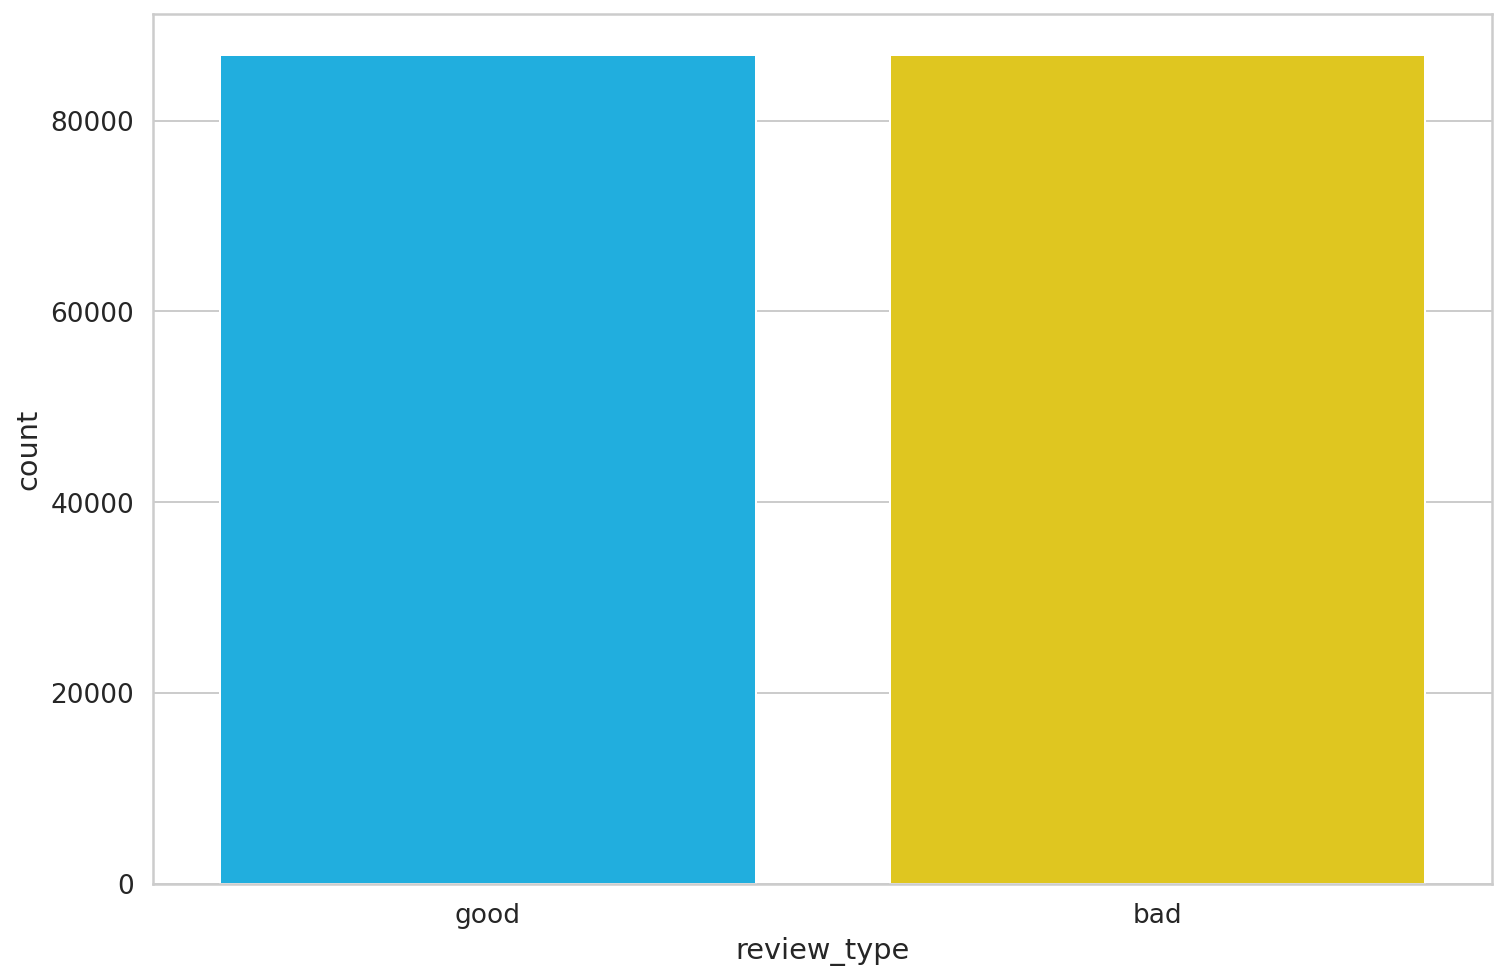

In [ ]:
sns.countplot(review_df.review_type)

Universal Sentence Encoder 

In [ ]:
use= hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3")

In [ ]:
sent_1=['the location is great']
sent_2 = ['amazing location']

In [ ]:
emb_1=use(sent_1)
emb_2=use(sent_2)

In [ ]:
emb_1.shape """can extract sentence similarity using numpy because the tensors are normalized to 1"""

In [ ]:
np.inner(emb_1, emb_2).flatten()[0] #will normalize between 0 and 1 hw similar these sentences are, the closer to 1, the more similar the sent are

0.79254675

Preprocessing


In [ ]:
"""Step one: convert the reviews into one hot encoded vectors"""

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
type_one_hot=OneHotEncoder(sparse= False).fit_transform(
    review_df.review_type.to_numpy().reshape(-1, 1)
)

In [ ]:
type_one_hot.shape

(173702, 2)

In [ ]:
train_reviews, test_reviews, y_train, y_test =\
  train_test_split(review_df.review, type_one_hot, test_size=.1, random_state= RANDOM_SEED)

In [ ]:
"""Use use and convert the text into embeddings, iterate over every review and append the embeddings to Xtrain"""
##use tqdm in order to observe the progress
X_train =[]
for r in tqdm(train_reviews):
  emb=use(r)
  review_emb = tf.reshape(emb, [-1]).numpy()
  X_train.append(review_emb)

X_train =np.array(X_train)

100%|██████████| 156331/156331 [3:11:01<00:00, 13.64it/s]


In [ ]:
X_test =[]
for r in tqdm(test_reviews):
  emb=use(r)
  review_emb = tf.reshape(emb, [-1]).numpy()
  X_test.append(review_emb)

X_test =np.array(X_test)

100%|██████████| 17371/17371 [20:53<00:00, 13.86it/s]


Saving model at checkpoints

Sentiment Analysis

In [ ]:
model = keras.Sequential()

model.add(
    keras.layers.Dense(
        units=256,
        input_shape=(X_train.shape[1], ),
        activation='relu'
    )
)

model.add(keras.layers.Dropout(rate=.5))

model.add(
    keras.layers.Dense(
        units=128,
        activation = 'relu'
    )
)

model.add(keras.layers.Dropout(rate=.5))

model.add(keras.layers.Dense(2, activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs = 10,
    batch_size=16,
    validation_split = .1,
    verbose=1,
    shuffle = True
)

Epoch 1/10
8794/8794 [==============================] - 21s 2ms/step - loss: 0.4341 - accuracy: 0.7973 - val_loss: 0.4035 - val_accuracy: 0.8141
Epoch 2/10
8794/8794 [==============================] - 20s 2ms/step - loss: 0.4128 - accuracy: 0.8105 - val_loss: 0.3924 - val_accuracy: 0.8181
Epoch 3/10
8794/8794 [==============================] - 21s 2ms/step - loss: 0.4043 - accuracy: 0.8158 - val_loss: 0.3907 - val_accuracy: 0.8176
Epoch 4/10
8794/8794 [==============================] - 20s 2ms/step - loss: 0.3983 - accuracy: 0.8191 - val_loss: 0.3866 - val_accuracy: 0.8190
Epoch 5/10
8794/8794 [==============================] - 20s 2ms/step - loss: 0.3911 - accuracy: 0.8224 - val_loss: 0.3892 - val_accuracy: 0.8200
Epoch 6/10
8794/8794 [==============================] - 20s 2ms/step - loss: 0.3867 - accuracy: 0.8256 - val_loss: 0.3846 - val_accuracy: 0.8203
Epoch 7/10
8794/8794 [==============================] - 21s 2ms/step - loss: 0.3813 - accuracy: 0.8291 - val_loss: 0.3837 - val_ac

In [ ]:
import os
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# Train the model with the new callback
model.fit(X_train, y_train,  
          epochs=10,
          validation_data=(X_test, y_test),
          callbacks=[cp_callback])  # Pass callback to training

# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.

Epoch 1/10
4886/4886 [==============================] - 14s 3ms/step - loss: 0.3615 - accuracy: 0.8388 - val_loss: 0.3944 - val_accuracy: 0.8203

Epoch 00001: saving model to training_1/cp.ckpt
Epoch 2/10
4886/4886 [==============================] - 14s 3ms/step - loss: 0.3556 - accuracy: 0.8417 - val_loss: 0.3946 - val_accuracy: 0.8176

Epoch 00002: saving model to training_1/cp.ckpt
Epoch 3/10
4886/4886 [==============================] - 14s 3ms/step - loss: 0.3519 - accuracy: 0.8429 - val_loss: 0.3999 - val_accuracy: 0.8185

Epoch 00003: saving model to training_1/cp.ckpt
Epoch 4/10
4886/4886 [==============================] - 14s 3ms/step - loss: 0.3468 - accuracy: 0.8467 - val_loss: 0.3960 - val_accuracy: 0.8194

Epoch 00004: saving model to training_1/cp.ckpt
Epoch 5/10
4886/4886 [==============================] - 14s 3ms/step - loss: 0.3444 - accuracy: 0.8478 - val_loss: 0.3956 - val_accuracy: 0.8197

Epoch 00005: saving model to training_1/cp.ckpt
Epoch 6/10
4886/4886 [========

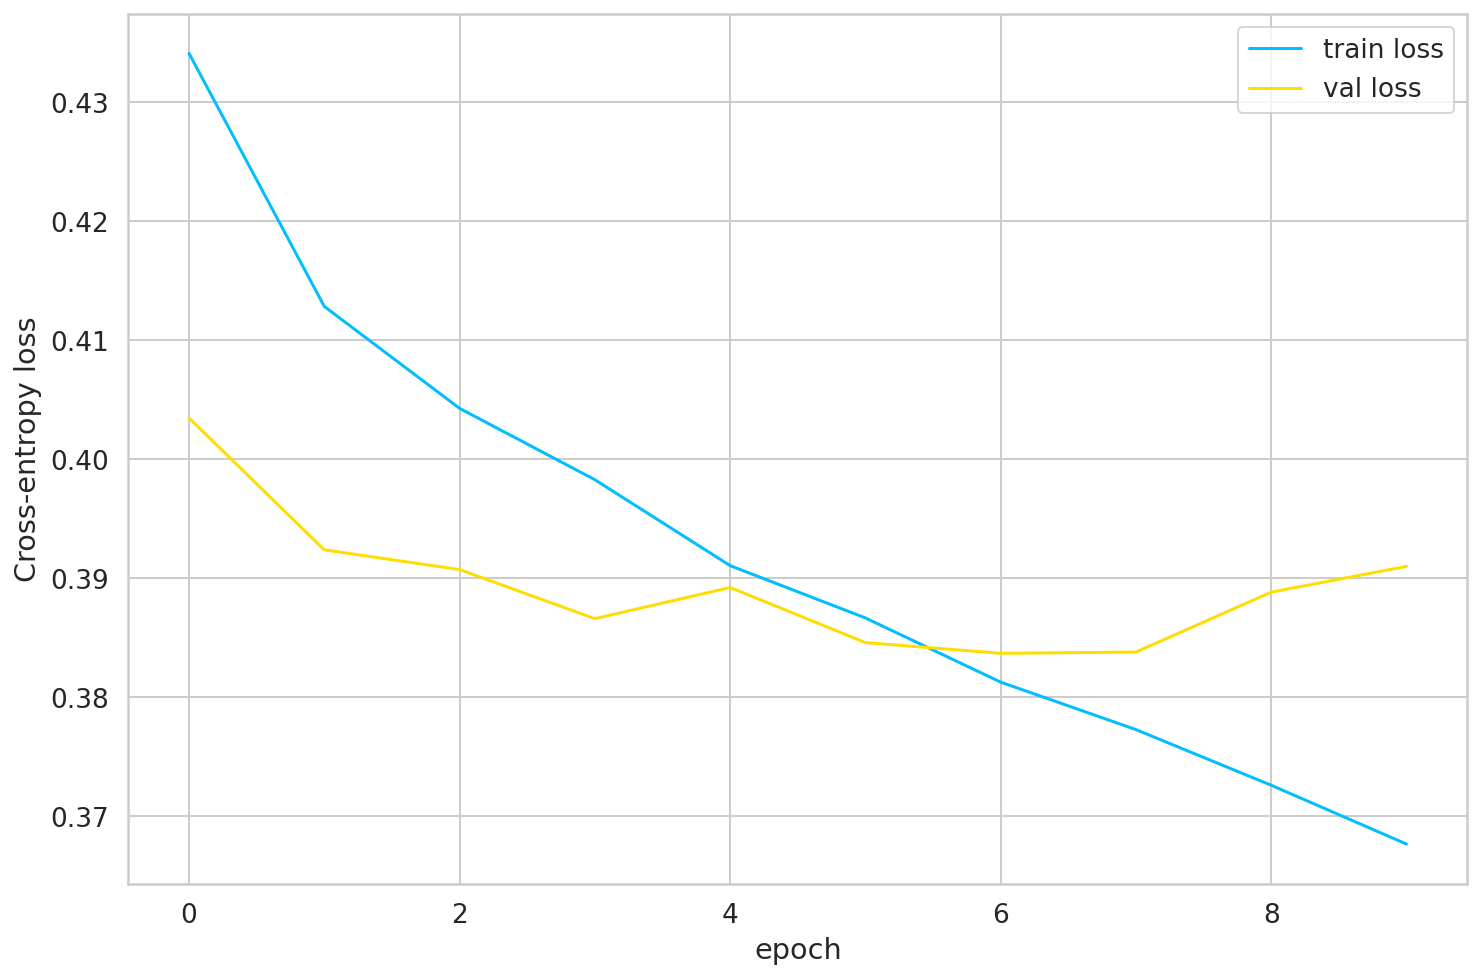

In [ ]:
plt.plot(history.history['loss'], label = 'train loss')
plt.plot(history.history['val_loss'], label = 'val loss')
plt.xlabel("epoch")
plt.ylabel("Cross-entropy loss")
plt.legend();

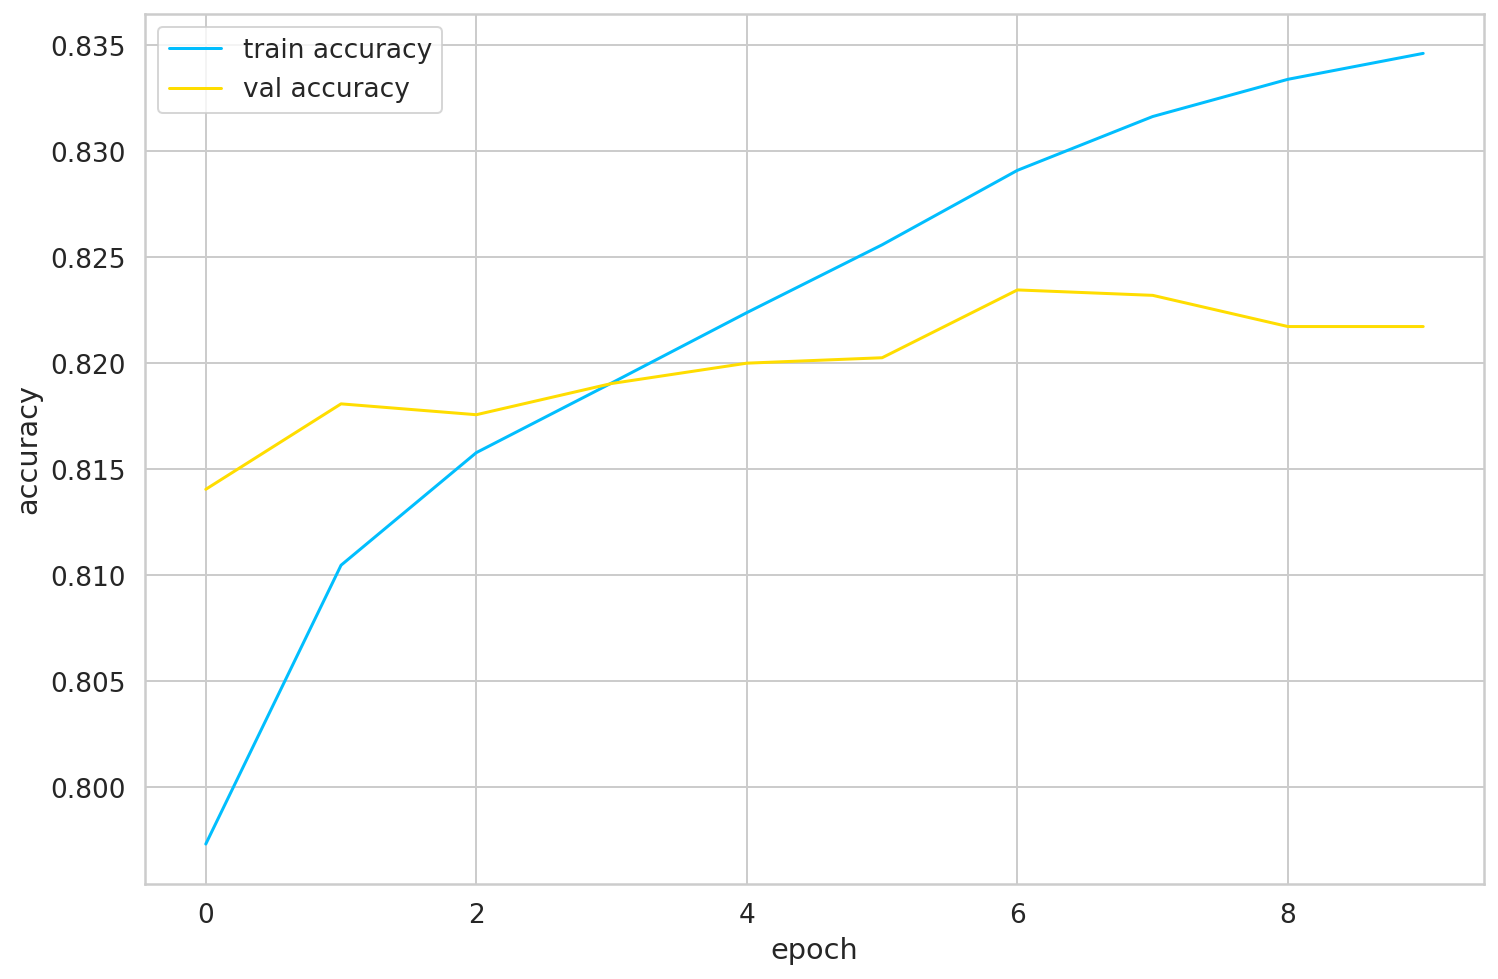

In [ ]:
plt.plot(history.history['accuracy'], label = 'train accuracy')
plt.plot(history.history['val_accuracy'], label = 'val accuracy')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend();

In [ ]:
model.evaluate(X_test, y_test)

543/543 [==============================] - 1s 1ms/step - loss: 0.4030 - accuracy: 0.8176


[0.402973473072052, 0.8176270723342896]

make predictions!

In [ ]:
print(test_reviews.iloc[0])

 Asked for late checkout and didnt get an answer then got a yes but had to pay 25 euros by noon they called to say sorry you have to leave in 1h knowing that i had a sick dog and an appointment next to the hotel  Location staff 


In [ ]:
print("Bad" if y_test[0][0]== 1 else "Good")

Bad


In [ ]:
y_pred = model.predict(X_test[:1])

In [ ]:
print(y_pred)

[[0.88868135 0.11131869]]


In [ ]:
print(test_reviews.iloc[1])

 Don t really like modern hotels Had no character Bed was too hard  Good location rooftop pool new hotel nice balcony nice breakfast 


In [ ]:
print("Bad" if y_test[1][0]== 1 else "Good")

Good


In [ ]:
model.predict(X_test[2:3])

array([[0.2642079 , 0.73579216]], dtype=float32)

In [ ]:
# Loads the weights
# model.load_weights(checkpoint_path)

# # Re-evaluate the model
# loss, acc = model.evaluate(test_images, test_labels, verbose=2)
# print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

NameError: ignored